# Multivariate regression to predict the wind speed field

In [1]:
import torch
import torch.nn as nn
import numpy as np

from utils.data_loaders import get_wake_dataloaders
import utils.utils as utils
import utils.data_utils as data_utils 
from utils.metrics import MetricsLogger, RMSELoss
import utils.plotting as plotting

# define random seeds for Neural Networks
torch.manual_seed(0)
np.random.seed(0)

In [2]:
HIDDEN_LAYERS_UNITS = [50, 500]

class MultivariateNN(nn.Module):
    def __init__(self, input_space, output_space) -> None:
        super(MultivariateNN, self).__init__()
        layer_units = [input_space] + HIDDEN_LAYERS_UNITS + [output_space]
        layers = list()
        for first, second in zip(layer_units, layer_units[1:]):
            layers += [nn.Linear(first, second), nn.Sigmoid()]
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

#TODO add regularization term in the loss function?

In [3]:
FACTORS_FOLDER = "discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01"
DATA_FOLDER = f"data/{FACTORS_FOLDER}/"
MODEL_NAME = f"multivariate_NN_layers{'-'.join(str(lu) for lu in HIDDEN_LAYERS_UNITS)}"
BEST_MODEL_PATH = f"saved_models/{FACTORS_FOLDER}/{MODEL_NAME}.pt"
CONSIDER_WS = False
COORDS_AS_INPUT = False # multivariate setting
if CONSIDER_WS:
    MODEL_NAME += "_consider_ws"
    BEST_MODEL_PATH = f"saved_models/{FACTORS_FOLDER}/{MODEL_NAME}.pt"\
        .replace("TIstep0.01_CTstep0.01", "reducedTI-CT")
    print(MODEL_NAME)
    print(BEST_MODEL_PATH)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{DEVICE=}")

# hyperparameters
BATCH_SIZE = 8
EPOCHS = 300
LR = 0.0001

DEVICE=device(type='cpu')


In [ ]:
valid_dataloader = None
train_dataloader, valid_dataloader, test_dataloader = get_wake_dataloaders(DATA_FOLDER,
                                                          consider_ws=CONSIDER_WS,
                                                          coords_as_input=COORDS_AS_INPUT,
                                                          train_perc=0.6,
                                                          test_perc=0.2,
                                                          validation_perc=0.2,
                                                          batch_size=BATCH_SIZE)
len(train_dataloader)

In [ ]:
for b in train_dataloader:
    print(b[0].shape, b[1].shape)
    break

input_space = train_dataloader.dataset.inputs.shape[1]
output_space = train_dataloader.dataset.outputs.shape[1]
print(f"{input_space=}\t{output_space=}")

torch.Size([8, 2]) torch.Size([8, 7168])
input_space=2	output_space=7168


Logging multivariate_NN_layers50-500
Epoch 0 ->	Training loss (MSE)=0.014382334539302185	Training RMSE=0.08010247909976531	Validation loss (MSE)=0.0008951220424510105	Validation RMSE=0.02745272343501795	
Epoch 1 ->	Training loss (MSE)=0.0007293934314087568	Training RMSE=0.02597685812633167	Validation loss (MSE)=0.0006882616731292179	Validation RMSE=0.022746023791300696	
Epoch 2 ->	Training loss (MSE)=0.0006437400360108902	Training RMSE=0.023969234947779382	Validation loss (MSE)=0.0006596547646040563	Validation RMSE=0.020990305348451054	
Epoch 3 ->	Training loss (MSE)=0.0006271627378314301	Training RMSE=0.023670520942456037	Validation loss (MSE)=0.0006454655374190499	Validation RMSE=0.021397865728236907	
Epoch 4 ->	Training loss (MSE)=0.0006184757200508313	Training RMSE=0.023376571695327527	Validation loss (MSE)=0.0006524627102873298	Validation RMSE=0.022165463160896716	
Epoch 5 ->	Training loss (MSE)=0.0006136534748871471	Training RMSE=0.02330042410699665	Validation loss (MSE)=0.000630

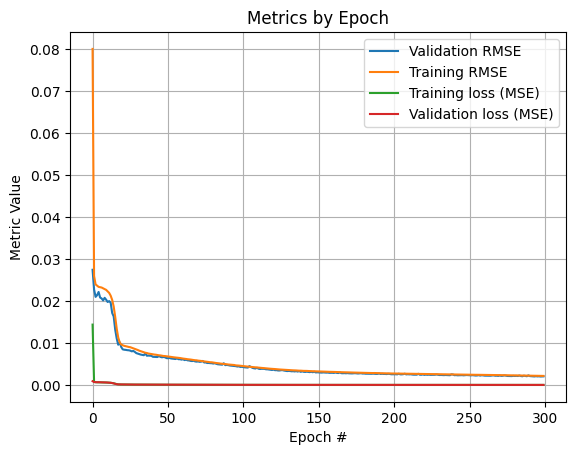

Metrics exported in the following csv file: logged_metrics/multivariate_NN_layers50-500_31-05-2023_18-31-05.csv


In [ ]:
model = MultivariateNN(input_space, output_space).to(DEVICE)

optimizer = torch.optim.Adam(
    (p for p in model.parameters() if p.requires_grad), lr=LR
)

loss_function = torch.nn.MSELoss()
#rmse_function = RMSELoss()

metrics_logger = MetricsLogger(name=MODEL_NAME)
best_v_loss = 1_000_000.
for epoch in range(EPOCHS):
    '''TRAINING'''
    model.train(True)
    epoch_t_loss = 0
    epoch_t_rmse = 0
    for batch in iter(train_dataloader):
        input_features, wake_field = batch[0].to(DEVICE), batch[1].to(DEVICE)
        optimizer.zero_grad()
        prediction = model.forward(input_features)
        tloss = loss_function(prediction, wake_field)
        tloss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) TODO
        optimizer.step()

        epoch_t_loss += tloss.item() * input_features.size(0)

        # other metrics
        #rmse = rmse_function(prediction, wake_field)
        #epoch_t_rmse += rmse.item() * input_features.size(0)

    avg_t_loss = epoch_t_loss / len(train_dataloader.sampler)
    #avg_t_rmse = epoch_t_rmse / len(train_dataloader.sampler)
    metrics_logger.log_metric(epoch, 'Training loss (MSE)', avg_t_loss)
    #metrics_logger.log_metric(epoch, 'Training RMSE', avg_t_rmse)

    '''VALIDATION'''
    if valid_dataloader:
        model.train(False)
        epoch_v_loss = 0
        epoch_v_rmse = 0
        for batch in iter(valid_dataloader):
            input_features, wake_field = batch[0].to(DEVICE), batch[1].to(DEVICE)
            prediction = model(input_features)
            
            vloss = loss_function(prediction, wake_field)
            epoch_v_loss += vloss.item() * input_features.size(0)
            #rmse = rmse_function(prediction, wake_field)
            #epoch_v_rmse += rmse.item() * input_features.size(0)

        avg_v_loss = epoch_v_loss / len(valid_dataloader.sampler)
        #avg_v_rmse = epoch_v_rmse / len(valid_dataloader.sampler)
        metrics_logger.log_metric(epoch, 'Validation loss (MSE)', avg_v_loss)
        #metrics_logger.log_metric(epoch, 'Validation RMSE', avg_v_rmse)
        # Track best performance, and save the model's state
        if avg_v_loss < best_v_loss:
            best_vloss = avg_v_loss
            torch.save(model.state_dict(), BEST_MODEL_PATH)

metrics_logger.plot_metrics_by_epoch()
metrics_logger.save_metrics()

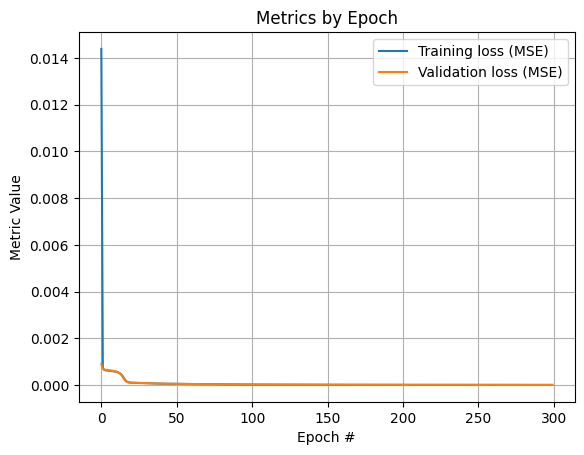

In [ ]:
#metrics_logger = MetricsLogger.from_csv("logged_metrics/multivariateNNlayers50-500_30-05-2023_00-46-45.csv")
metrics_logger.plot_metrics_by_epoch(["Training loss (MSE)", "Validation loss (MSE)"])

# Testing

In [ ]:
from utils.evaluation import test_pytorch_model
test_pytorch_model(model, test_dataloader, model_description=MODEL_NAME, save_results=True)

Testing results: avg loss=4.002709230063416e-06 on an avg deficit per wake of 0.019734064117074013


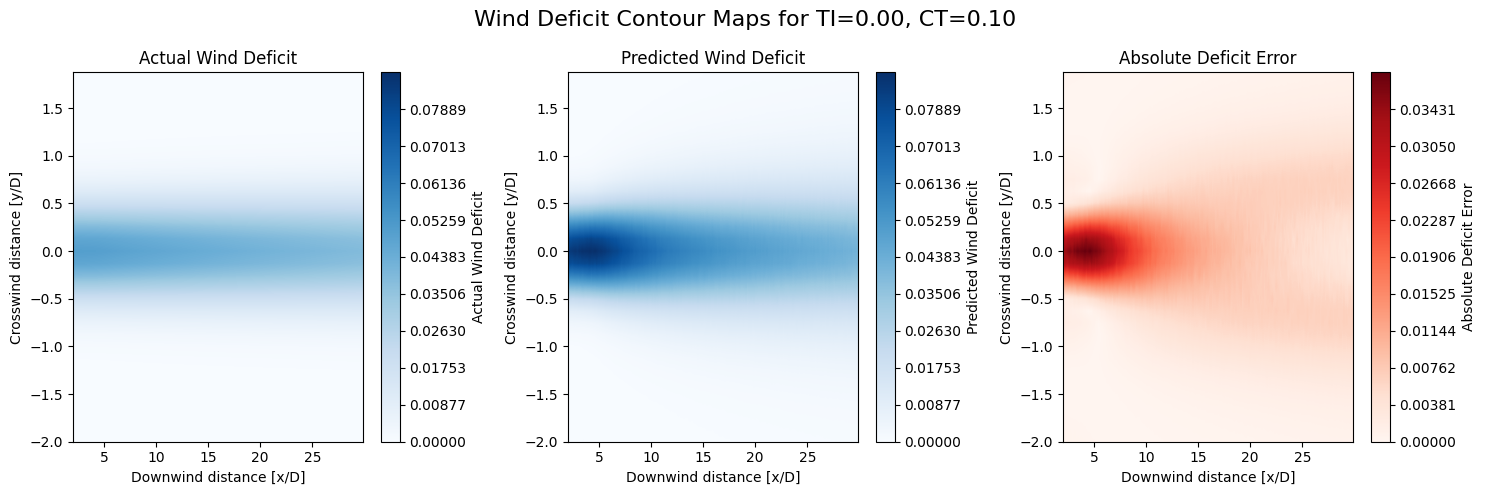

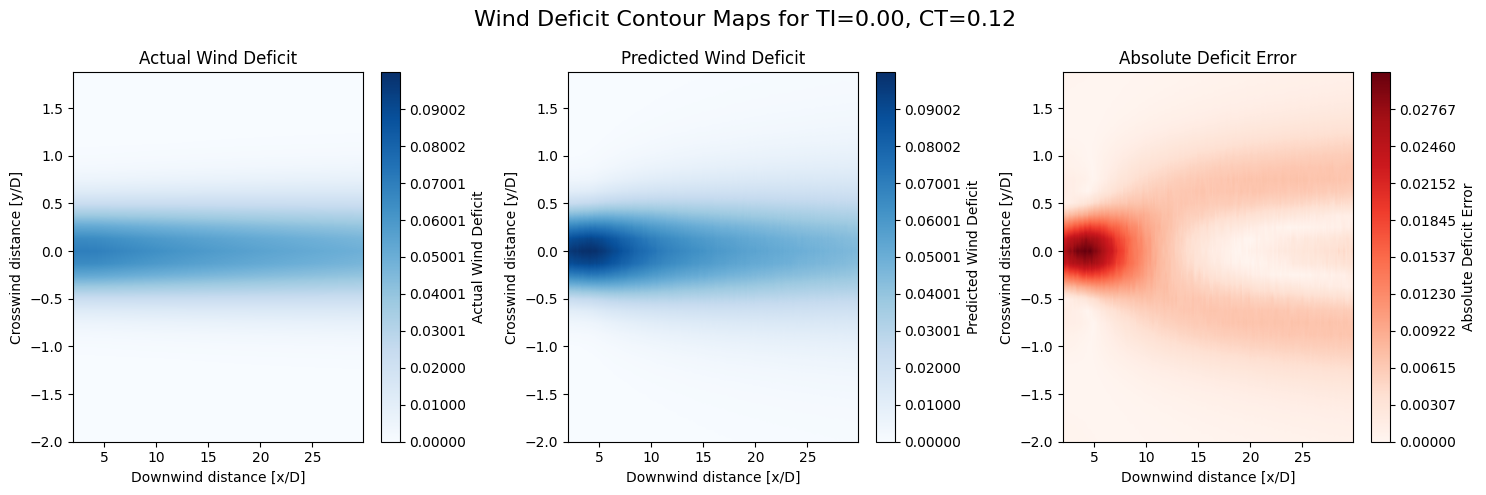

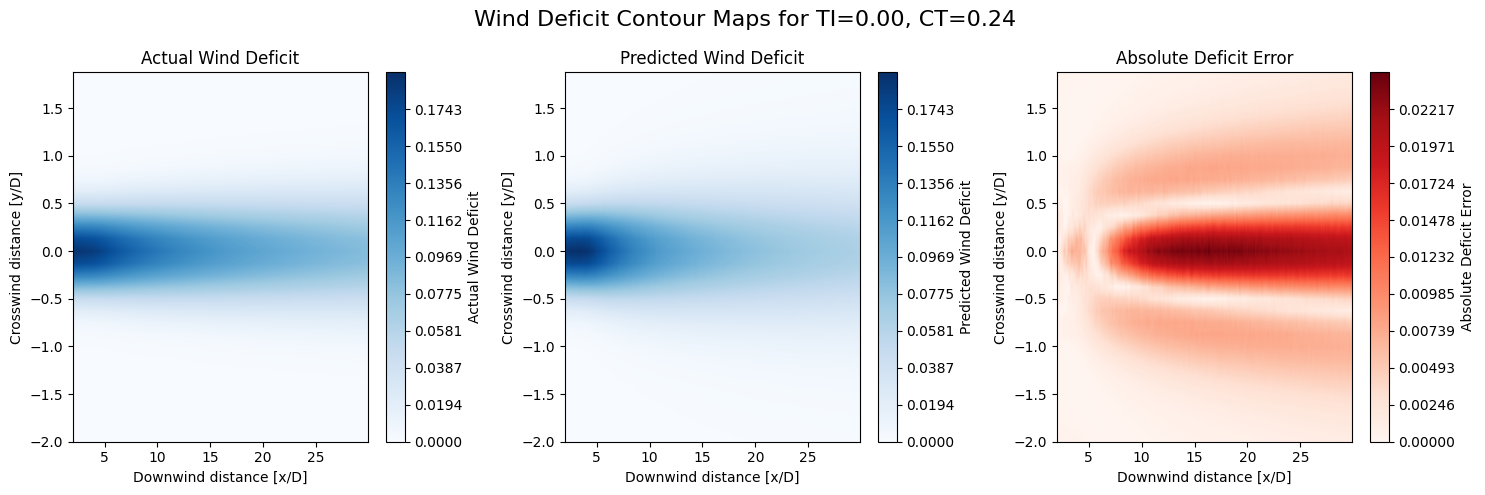

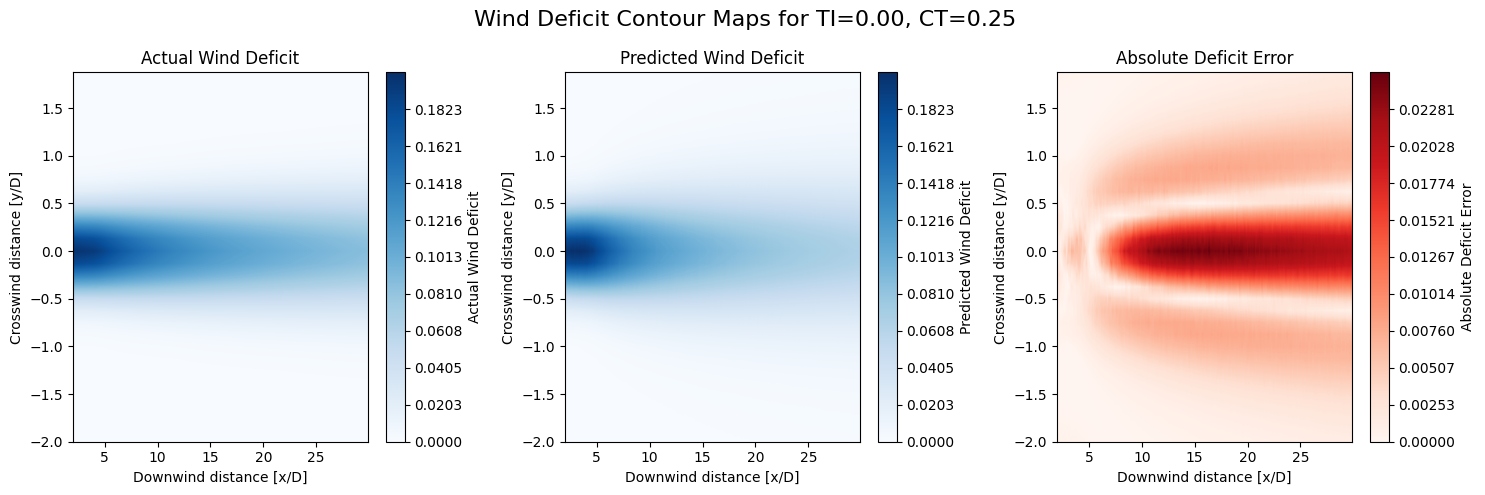

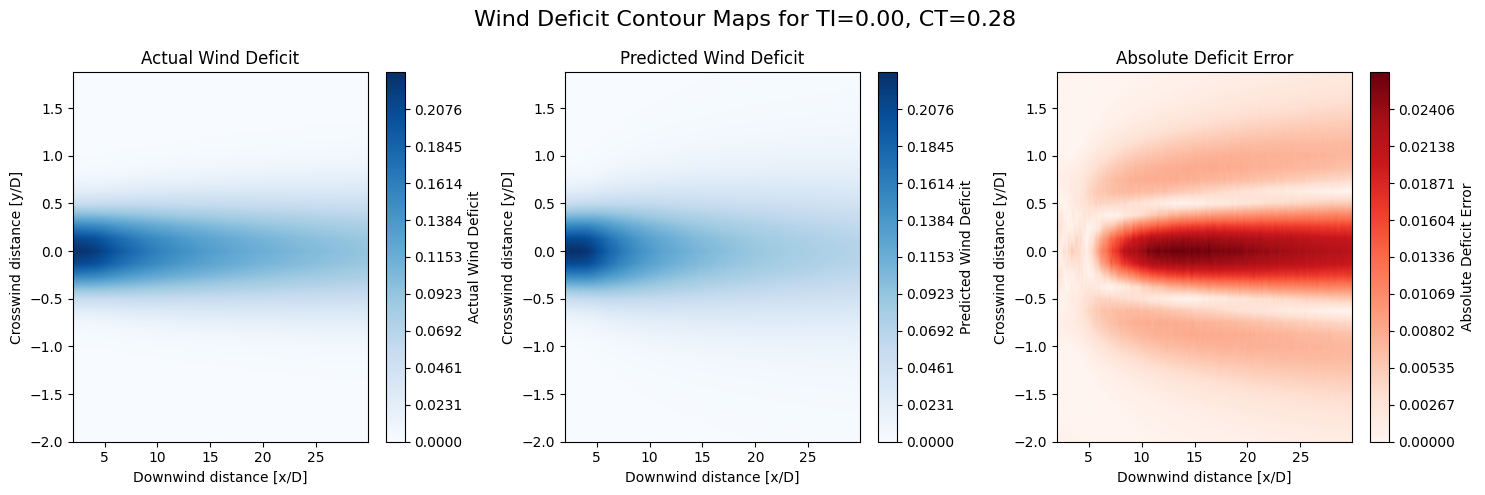

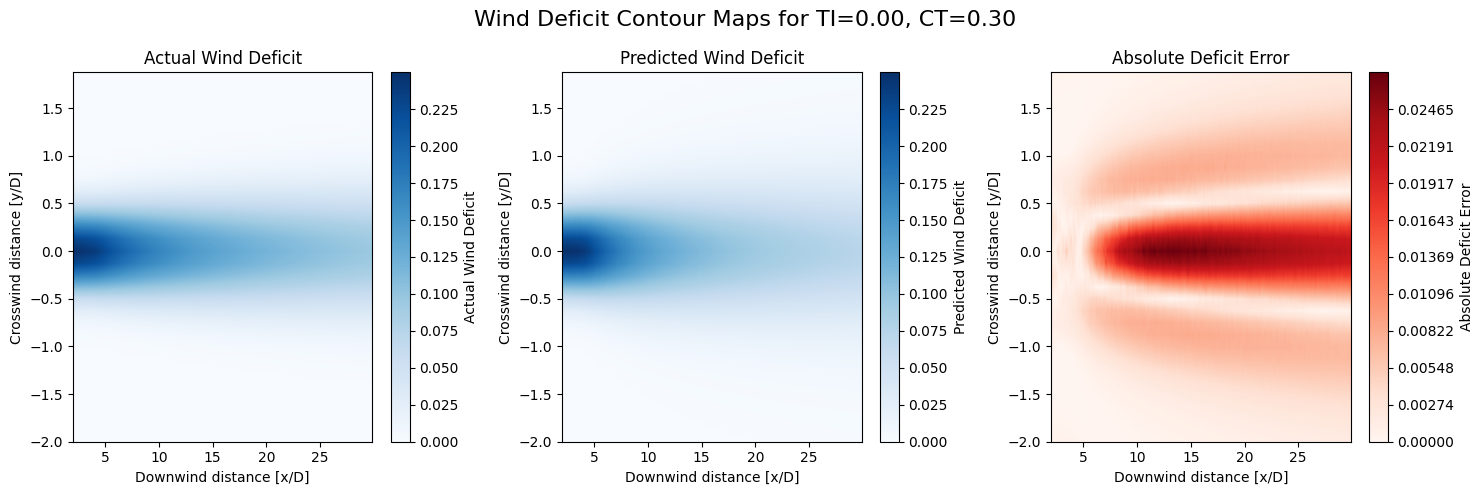

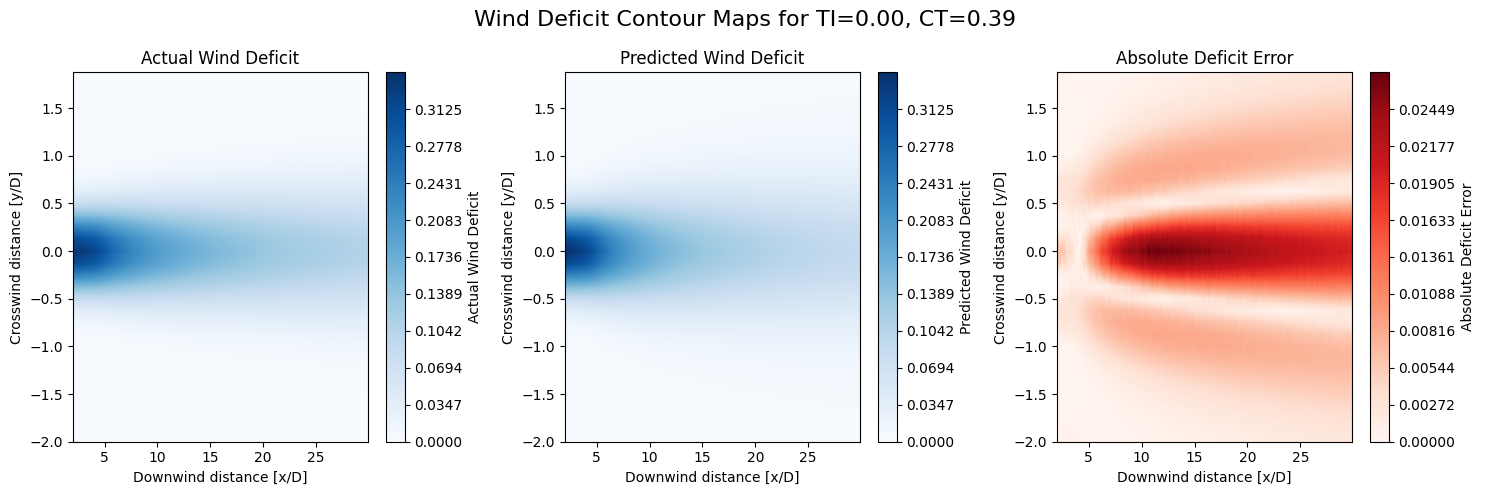

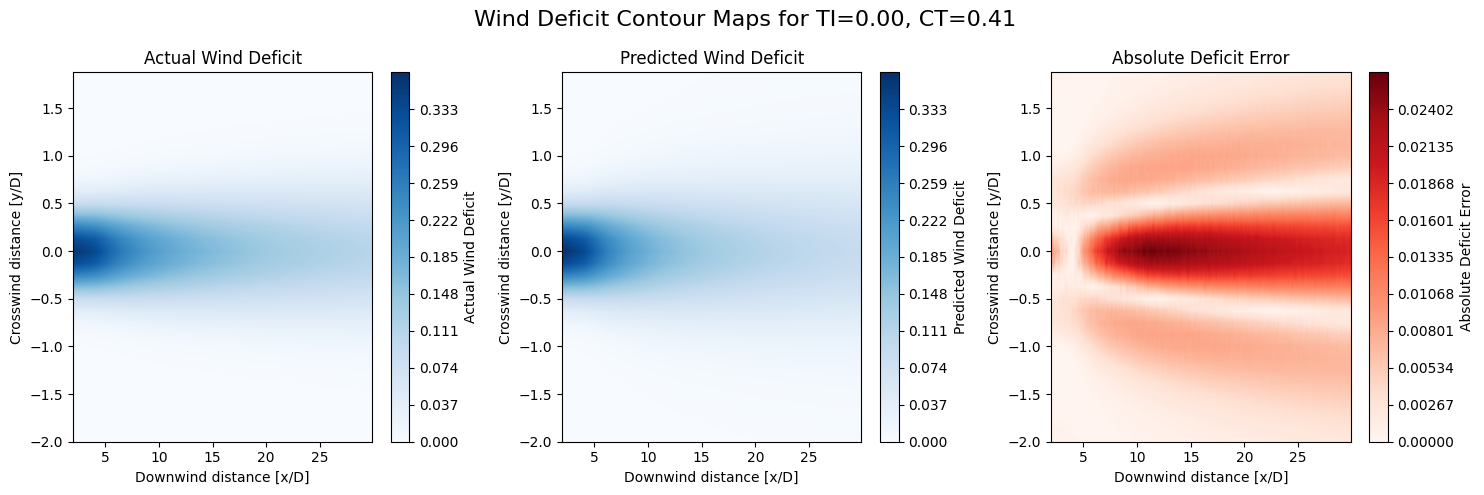

KeyboardInterrupt: 

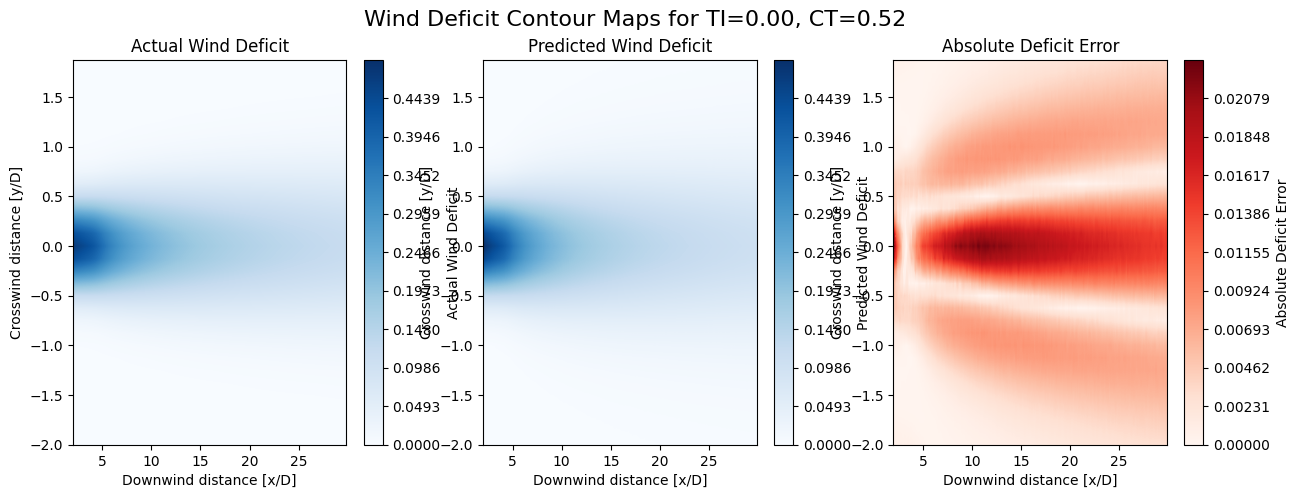

In [ ]:
dataset = test_dataloader.dataset
with torch.no_grad():
    for idx in range(len(dataset)):
        ti, ct, ws, wake_field, predicted_wake_field = dataset.get_parameters_for_plotting_multivariate(model, idx)
        
        plotting.plot_maps(dataset.X_grid, dataset.Y_grid, wake_field, predicted_wake_field, ti, ct, ws, error_to_plot='absolute')